# Немного sql

In [1]:
# импорт библиотек

import pandahouse as ph

### 1.1 Запрос на расчет количества усердных студентов

Образовательные курсы состоят из различных уроков, каждый из которых состоит из нескольких маленьких заданий.

Усердный студент - тот пользователь, который хотя бы раз за текущий месяц правильно решил от 20 заданий.

Ниже представлен запрос, который даст информацию о количестве усердных студентов.

Данные представлены в виде таблицы со следующими колонками: 

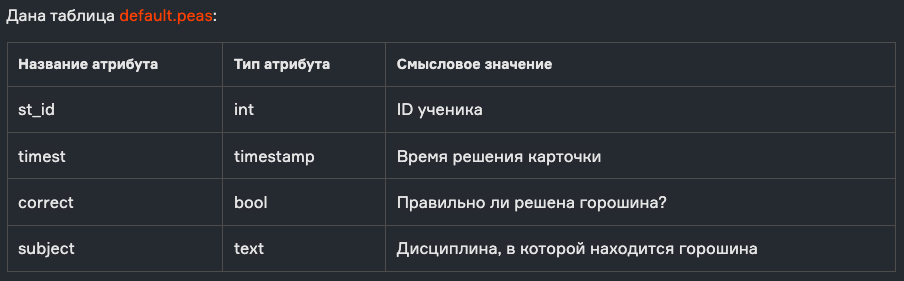

In [2]:
# параметры подключения

connection = dict(database='default',
                  host='https://clickhouse.lab.karpov.courses',
                  user='student',
                  password='dpo_python_2020')

In [3]:
sql_query_one = """
SELECT COUNT(st_id) AS diligent_st_count
FROM (
    SELECT st_id, SUM(correct) as correct_sum
    FROM default.peas
    WHERE toStartOfMonth(timest) IN 
        (SELECT toStartOfMonth(MAX(timest)) 
        FROM peas)
    GROUP BY st_id
    HAVING correct_sum >= 20)
"""

In [4]:
diligent_st_count = ph.read_clickhouse(sql_query_one, connection=connection)

print("Количество усердных студентов:", diligent_st_count.iat[0, 0])

Количество усердных студентов: 136


### 1.2 Выгрузка метрик 

Образовательная платформа предлагает пройти студентам курсы по модели trial: студент может решить бесплатно только 30 заданий в день. Для неограниченного количества заданий в определенной дисциплине студенту необходимо приобрести полный доступ. Команда провела эксперимент, где был протестирован новый экран оплаты.

Необходимо в одном запросе выгрузить следующую информацию о контрольной и тестовой группах пользователей:
* ARPU 
* ARPAU 
* CR в покупку 
* СR активного пользователя в покупку 
* CR пользователя из активности по математике (subject = ’math’) в покупку курса по математике

ARPU считается относительно всех пользователей, попавших в группы.

Активным считается пользователь, за все время решивший больше 10 заданий правильно в любых дисциплинах.

Активным по математике считается пользователь, за все время решивший правильно 2 или больше заданий по математике.

Таблицы с данными имеют следующий вид: 

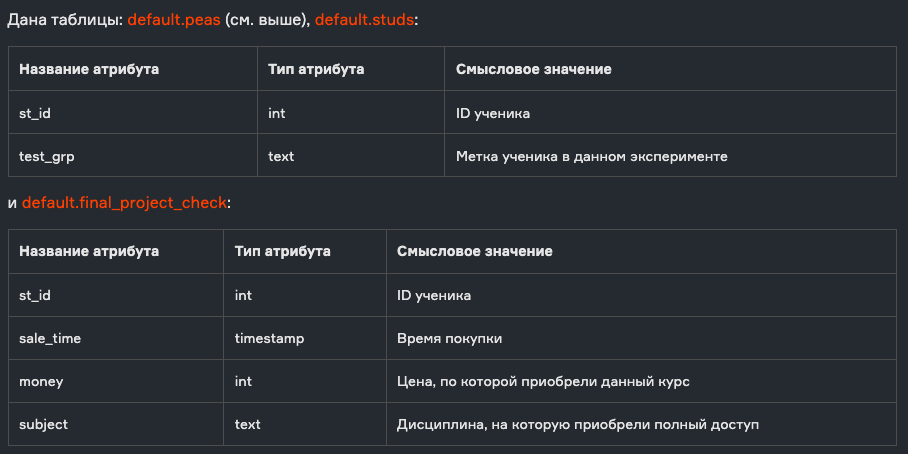

In [5]:
sql_query_second = """
SELECT
    test_grp,
    SUM(money)/count(DISTINCT st_id) AS ARPU,
    SUM(money_act)/countIf(score,score > 10) AS ARPAU,
    countIf(money, money > 0)/count(DISTINCT st_id)*100 AS CR_purchase,
    countIf(score, score > 10 AND money > 0)/countIf(score, score > 10)*100 AS CR_active,
    sumIf(math_pay, math_pay = 1)/sumIf(math_act, math_act = 1)*100 AS CR_active_math
FROM (
    SELECT
            a.st_id AS st_id,
            a.test_grp AS test_grp,
            b.money AS money,
            c.score AS score,
            CASE WHEN c.score > 10 THEN b.money ELSE 0 END AS money_act,
            b.math_pay AS math_pay,
            c.math_act AS math_act
        FROM studs AS a
    LEFT JOIN (
            SELECT
                st_id,
                SUM(money) AS money,
                MAX(CASE WHEN subject = 'Math' THEN 1 ELSE 0 END) AS math_pay
            FROM final_project_check 
            GROUP BY st_id) AS b 
    ON a.st_id = b.st_id
    LEFT JOIN (
            SELECT
                st_id,
                SUM(score) AS score,
                SUM(math_act) AS math_act
            FROM (
                SELECT
                    st_id,
                    SUM(correct) AS score,
                    CASE WHEN subject = 'Math' and score >= 2 THEN 1 ELSE 0 END AS math_act
                FROM peas
                GROUP BY
                    st_id,
                    subject)
            GROUP BY st_id) AS c
    ON a.st_id = c.st_id
    )
GROUP BY test_grp
"""      

In [6]:
metrics = ph.read_clickhouse(sql_query_second, connection=connection)

metrics

,test_grp,ARPU,ARPAU,CR_purchase,CR_active,CR_active_math
0,control,4540.983607,10393.700787,4.918033,11.023622,16.326531
1,pilot,11508.474576,29739.583333,10.847458,26.041667,38.095238
